## Learning relations with Logic Tensor Networks

This is a basic example in which we learn to ground binary predicates/relations. We define three relations $\mathrm{R_{A,A}},\mathrm{R_{B,B}},\mathrm{R_{A,B}}$ in the space of $[0,1]^2\times [0,1]^2$. I.e, they are binary relations of points in $[0,1]$. 

In [1]:
import logging;logging.basicConfig(level=logging.INFO);
import numpy as np;
import matplotlib.pyplot as plt; 
import logictensornetworks_wrapper as ltnw;

Set the number of random training samples, the maximum number of epochs and how often we query the knowledgebase sat level in training.

In [2]:
nr_samples=5
epochs=30000
track_sat_level=1000

We define the relations without actual training data purely through the use of binary, disjoint predicates $A,B\subseteq [0,1]^2$.

In [3]:
ltnw.predicate("A",2)
ltnw.predicate("B",2)

ltnw.variable("?data_A",2) # data that is of type A (provided later)
ltnw.variable("?data_B",2) # data that is of type B (provided later)
ltnw.axiom("forall ?data_A: A(?data_A)")
ltnw.axiom("forall ?data_B: ~A(?data_B)")

ltnw.axiom("forall ?data_B: B(?data_B)")
ltnw.axiom("forall ?data_A: ~B(?data_A)")

<tf.Tensor 'cond_3/Merge:0' shape=(1,) dtype=float32>

We use the predicates $A,B$ to define the relations. All points in $A$ are also in a relation $R_{A,A}$. All points in $B$ are also in a relation $R_{B,B}$. Two points, $a,b$ are in a relation $R_{A,B}$ if $a\in A$ and $b\in B$

In [4]:
ltnw.variable("?data",2);ltnw.variable("?data_2",2)
ltnw.predicate("R_A_A",4)
ltnw.axiom("forall ?data, ?data_2: (A(?data) & A(?data_2)) -> R_A_A(?data,?data_2)")
ltnw.axiom("forall ?data, ?data_2: R_A_A(?data,?data_2) -> (A(?data) & A(?data_2))")

ltnw.predicate("R_B_B",4) 
ltnw.axiom("forall ?data, ?data_2: (B(?data) & B(?data_2)) -> R_B_B(?data,?data_2)")
ltnw.axiom("forall ?data, ?data_2: R_B_B(?data,?data_2) -> (B(?data) & B(?data_2))")

ltnw.predicate("R_A_B",4)
ltnw.axiom("forall ?data, ?data_2: (A(?data) & B(?data_2)) -> R_A_B(?data,?data_2)")
ltnw.axiom("forall ?data, ?data_2: R_A_B(?data,?data_2) -> (A(?data) & B(?data_2))");

print("\n".join(sorted(ltnw.AXIOMS.keys())))



forall ?data, ?data_2: (A(?data) & A(?data_2)) -> R_A_A(?data,?data_2)
forall ?data, ?data_2: (A(?data) & B(?data_2)) -> R_A_B(?data,?data_2)
forall ?data, ?data_2: (B(?data) & B(?data_2)) -> R_B_B(?data,?data_2)
forall ?data, ?data_2: R_A_A(?data,?data_2) -> (A(?data) & A(?data_2))
forall ?data, ?data_2: R_A_B(?data,?data_2) -> (A(?data) & B(?data_2))
forall ?data, ?data_2: R_B_B(?data,?data_2) -> (B(?data) & B(?data_2))
forall ?data_A: A(?data_A)
forall ?data_A: ~B(?data_A)
forall ?data_B: B(?data_B)
forall ?data_B: ~A(?data_B)


Let's sample some date from an example domain. Data on the left is of type $A$, data on the right is of type $B$.

In [5]:
data_A=np.random.uniform([0,0],[.25,1.],(nr_samples,2)).astype(np.float32)
data_B=np.random.uniform([.75,0],[1.,1.],(nr_samples,2)).astype(np.float32)
data=np.concatenate([data_A,data_B])


Now we can initialize and optimize the knowledgebase. Notice that we pass variable values as feed_dict.

In [6]:
feed_dict={"?data_A" : data_A, "?data_B" : data_B, "?data" : data, "?data_2" : data}
ltnw.initialize_knowledgebase(initial_sat_level_threshold=.1,feed_dict=feed_dict)
sat_level=ltnw.train(track_sat_levels=1000,sat_level_epsilon=.99,max_epochs=epochs,feed_dict=feed_dict)


INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.6319107
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.6319107
INFO:logictensornetworks_wrapper:TRAINING 1000 sat level -----> 0.8633876
INFO:logictensornetworks_wrapper:TRAINING 2000 sat level -----> 0.8805893
INFO:logictensornetworks_wrapper:TRAINING 3000 sat level -----> 0.88801444
INFO:logictensornetworks_wrapper:TRAINING 4000 sat level -----> 0.89493895
INFO:logictensornetworks_wrapper:TRAINING 5000 sat level -----> 0.9209901
INFO:logictensornetworks_wrapper:TRAINING 6000 sat level -----> 0.9429976
INFO:logictensornetworks_wrapper:TRAINING 7000 sat level -----> 0.9488222
INFO:logictensornetworks_wrapper:TRAINING 8000 sat level -----> 0.9607011
INFO:logictensornetworks_wra

Check some values by hand. What is the mean truth for two datapoints from $A$ to be in relation $R_{A,A}$?

In [7]:
ltnw.variable("?v1",2);ltnw.variable("?v2",2);
np.mean(ltnw.ask("R_A_A(?v1,?v2)",feed_dict={"?v1" : data_A,"?v2" : data_A}))

0.9852635

What is the mean truth value for two points $a,b$ being in $R_{A,A}$ if $a\in A$ and $b\in B$?

In [8]:
np.mean(ltnw.ask("R_A_A(?v1,?v2)",feed_dict={"?v1" : data_A,"?v2" : data_B}))

0.007361044

What is the mean truth value for two points from $B$ to be in the relation $R_{A,A}$?

In [9]:
np.mean(ltnw.ask("R_A_A(?v1,?v2)",feed_dict={"?v1" : data_B,"?v2" : data_B}))

0.0020698593

Visualize results

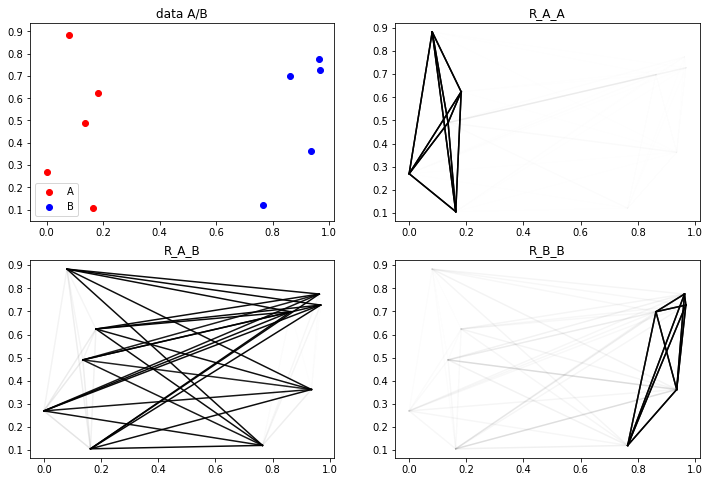

In [10]:
ltnw.variable("?data_A_2",data_A)
ltnw.variable("?data_B_2",data_B)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title("data A/B")
plt.scatter(data_A[:,0],data_A[:,1],c="red",alpha=1.,label="A")
plt.scatter(data_B[:,0],data_B[:,1],c="blue",alpha=1.,label="B")
plt.legend()

idx=2
for pred in ["R_A_A","R_A_B","R_B_B"]:
    result_A_A=ltnw.ask("%s(?data_A,?data_A_2)" % pred,feed_dict=feed_dict)
    result_A_B=ltnw.ask("%s(?data_A,?data_B)" % pred,feed_dict=feed_dict)
    result_B_B=ltnw.ask("%s(?data_B,?data_B_2)" % pred,feed_dict=feed_dict)
    plt.subplot(2,2,idx)
    idx+=1
    plt.title(pred)
    for i1,d1 in enumerate(data_A):
        for i2,d2 in enumerate(data_A):
            plt.plot([d1[0],d2[0]],[d1[1],d2[1]],alpha=result_A_A[i1,i2,0],c="black")            
    for i1,d1 in enumerate(data_A):
        for i2,d2 in enumerate(data_B):
            plt.plot([d1[0],d2[0]],[d1[1],d2[1]],alpha=result_A_B[i1,i2,0],c="black")
    for i1,d1 in enumerate(data_B):
        for i2,d2 in enumerate(data_B):
            plt.plot([d1[0],d2[0]],[d1[1],d2[1]],alpha=result_B_B[i1,i2,0],c="black")

plt.show()